<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE 40455 Process Operations](http://jckantor.github.io/CBE40455/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/CBE40455/).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), 
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Model Development in SimPy](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.02-Discrete-Event-Simulation-of-a-Batch-Process.ipynb) | [Contents](toc.ipynb) | [Spanky's Pizzeria](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Spanky's-Pizzeria.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.03-Queuing-Systems.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Queuing Systems

Queuing systems are a ubiquitous feature of business and engineering applications. Examples exist whereever you find descrete items passing through a system, such as cars through a toll booth, customers in line at a coffee shop, aircraft on a production line, orders at a contract pharmaceuticals manufacturer, patients in an emergency room, phone calls at a call center,  ...., well, you get idea. If you are reading these notes at work or in your college dorm room, chances are that you've already dealt with at least one queueing system today.

The generic pattern is 

    Arrivals ---->  Queuing System: Items in queue for processing ----> Departures

This notebook introduces a few basic elements of queuing theory from an empirical perspective. The main elements include simulation methods, the Poisson and Lognormal distributions commonly used to model the random elements of these systems, and Little's Law. Hopefully these tools provide practical insights to phenomenon everyone experiences in everyday life, and form a foundation for detailed modeling of the batch processes encountered in the process industries.

## Poisson Processes and Exponential Distributions

Suppose we told that certain events, for example the arrival of customer orders from a web page, occur at an average rate of $\lambda$ events per unit time. We assume these events are independent from one another, and the process behaves uniformly over time. How can this be modeled for the purpose of simulation? 

This is known as a **Poisson process**, one of the most widely studied and useful constructs in statistics and probability theory. Here are a few key facts about Poisson processes:

1. Given a average rate of events $\lambda$ per unit time, the probability of $n$ events occuring in a period $\tau$ is given by the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) \begin{align}\\ P(n;\lambda\tau) & = \frac{(\lambda\tau)^n e^{-\lambda\tau}}{n!}\\ & \end{align} This probability distribution has a mean $\lambda\tau$ and a standard deviation $\sqrt{\lambda\tau}$.

2. The time between events is given by the Exponential distribution with probability density function 
\begin{align}\\ f^{Exp}_\lambda(t) & = \lambda e^{-\lambda t}\\ & \end{align} This distribution has a mean $\frac{1}{\lambda}$ and a standard deviation $\frac{1}{\lambda}$.

Knowing the statistical distribution of time between events provides a convenient way to simulate the behavior of Poisson process. Given a average rate $\lambda$ of events per unit time, the technique is to draw random variables from an exponential distribution, then to wait that period of time before issuing another event.

### Example: Simulate Customers Arriving at a Known Rate

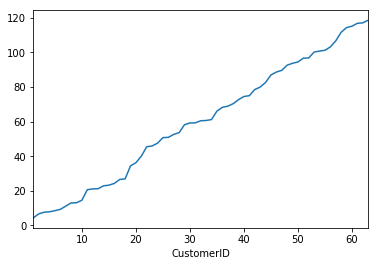

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2  # customers per minute

env = simpy.Environment()
log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        log.append([n, env.now, 'Arrival'])
        n += 1
        
env.process(customer_arrival(env,rate))
env.run(120)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df.head()

df['Time'].plot(kind='line')

## Let's Provide Some Service to the Customers

Our customers are just hanging around, waiting in line.  Let's provide some service by taking the customer's order.  We'll call this the 'service_time'. We introduce a FIFO customer_queue so that we service customers in the order in which they arrived.

Average rate of arrival = 0.5
Average wait time for completion of service =  7.46


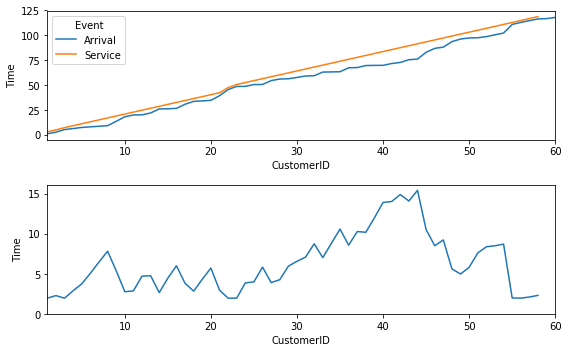

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2            # customers per minute
service_time = 1.95    # service time

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(service_time)
        log.append([n, env.now, 'Service'])
        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.run(120)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')

# plot log

plt.figure(figsize=(8,5))
ax1 = plt.subplot(2,1,1)
df.plot(ax = ax1, kind='line')
ax1.set_ylabel('Time')

df['Wait'] = df['Service'] - df['Arrival']
ax2 = plt.subplot(2,1,2)
df['Wait'].plot(ax=ax2)
ax2.set_ylim(ymin=0)
ax2.set_ylabel('Time')

plt.tight_layout()

# key performance measures

df['Wait'] = (df['Service']-df['Arrival']).mean()
rlambda = 1/df['Arrival'].diff().mean()
print('Average rate of arrival =', round(rlambda,2))
print('Average wait time for completion of service = ', round(W,2))

## Little's Law

Provided service time is less than 1/rate, the average time the customer experiences appears to remain bounded. The average time experience by the customer grows as the service_time approaches 1/rate, becoming unstable in time when service time is greater than 1/rate. But what about the number of customers in process? Is there anything we can say about how many customers waiting and in the process of being served?

[Little's law](http://web.mit.edu/sgraves/www/papers/Little's%20Law-Published.pdf) offers a profound insight into the behavior of queueing systems.  

| Symbol | Description |
| :----- | :---------- |
| $L$    | Average number of items in the queuing system |
| $\lambda$ | Average rate of arrivals (= average rate of departures for a stable system) |
| $W$    | Average waiting time |

Little's law says

$$L = \lambda W$$

This seems simple enough in that perspective, but the catch is prove this it is true for any queuing system, even systems with complex organizations, and under for wide variety of statistical situations.

### Some analogies

The rule may seem particularly obvious to chemical engineers familiar with material balances where $\lambda$ corresponds to flowrate, $L$ to inventory, in which case $W$ takes the interpretation of average 'residence time'. 

| Discipline | Inventory | Rate | Time | Relationship |
| :--------- | :------- | :--: | :--: | :----------: |
| Queuing | $L$ (Items in Process) | $\lambda$ (Arrival Rate) | $W$ (Wait) | $L = \lambda W$ |
| Business | $WIP$ (Work in Progress) | $Th$ (Throughput) | $CT$ (Cycle Time) | $WIP = CT \times Th$ |
| Process Engineering | $V$ (Volume) | $q$ (Flowrate) | $\tau$ (Residence Time) | $V = \tau q$ |

### Why is this important?

Any manager of, say, an hospital emergency room would like high throughput of patients (i.e., large $\lambda$), short waiting time $W$, and low count in the waiting and treatment rooms (i.e., small $L$). Litte's law says this isn't possible. You can specify two of the parameters but the third will be dictated by Little's law. In particular, if the arrival rate $\lambda$ is set by externally, then the only way to reduce the patient count $L$ is to find ways to reduce the average wait time by processing cases faster.

Average rate of arrival = 0.5
Average wait time for completion of service =  7.46
Average number in queue and being served =  3.16


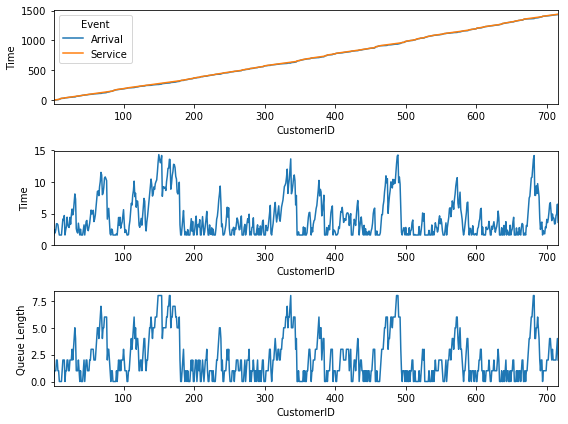

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2            # customers per minute
service_time = 1.6    # service time

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, 'Arrival', env.now, len(customer_queue.items)])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(service_time)
        log.append([n, 'Service', env.now, len(customer_queue.items)])
        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Event','Time','Queue'])
df = df.set_index('CustomerID')

# plot time of events

df_time = df.pivot(columns='Event',values='Time')
df_queue = df.pivot(columns='Event',values='Queue')

plt.figure(figsize=(8,6))
ax1 = plt.subplot(3,1,1)
df_time.plot(ax = ax1, kind='line')
ax1.set_ylabel('Time')

df_time['Wait'] = df_time['Service'] - df_time['Arrival']
ax2 = plt.subplot(3,1,2)
df_time['Wait'].plot(ax=ax2)
ax2.set_ylim(ymin=0)
ax2.set_ylabel('Time')

ax3 = plt.subplot(3,1,3)
df_queue['Arrival'].plot(ax=ax3)
ax3.set_ylabel('Queue Length')

plt.tight_layout()

# key performance measures

df_time['Wait'] = (df_time['Service']-df_time['Arrival']).mean()
rlambda = 1/df_time['Arrival'].diff().mean()
L = 1 + df_queue['Arrival'].mean()


print('Average rate of arrival =', round(rlambda,2))
print('Average wait time for completion of service = ', round(W,2))
print('Average number in queue and being served = ', round(L,2))

## Lognormal Distributions of Service Time

### Normal Distributions

A Normal distribution (also commonly called a Gaussian distribution) is usually the first (and too frequently the only) example of a statistical distribution encountered by engineering students. It is the common 'bell-shaped' curve described by the equation

$$ f^N_{\mu_X,\sigma_X}(x) = \frac{1}{\sqrt{2\pi\sigma_X^2}}e^{-\frac{(x-\mu_X)^2}{2\sigma_X^2}} $$

where $\mu_X$ is the mean and $\sigma_X$ is the standard deviation for the random variable $X$.  It has a lot of favoriable properities and is often a good starting point for the description of random phenomena.

Is it useful for modeling service times?

Let's look at a typical plot of the probability density function

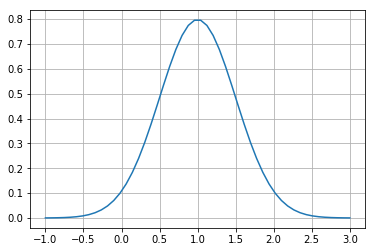

In [191]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

mu = 1
sigma = 0.5

x = np.linspace(mu-4*sigma,mu+4**sigma)
f_x = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x - mu)**2/2/sigma**2)

plt.plot(x,f_x)
plt.grid()

You already know how to fit a Normal distribution to data. Given a set of experimental values $x_1, x_2, \ldots, x_N$, the most commonly used estimates of $\mu_x$ is 

$$\hat{\mu}_X = \bar{x} =  \frac{1}{N} \sum_{k=1}^N x_k$$

and of $\sigma_x$ is 

$$\hat{\sigma}_X = s_X = \sqrt{\frac{1}{N-1}\sum_{k=1}^N (x_k - \bar{x})}$$

This all familiar and easy enought. But we can immediately see a problem using this as a model of service time. This distribution would allow for negative service times, which doesn't make physical sense.

### Lognormal Distribution

Suppose to have measurements of service times $t_1, t_2, \ldots, t_N$. By their nature, these times are all non-negative numbers. We take logarithms

$$x_k = \ln(t_k)$$

and find the logarithms have mean $\mu_X$ and standard deviation $\sigma_X$. What can we say about the distribution of service times?

Under these conditions, the service time distribution is **Lognormal**. The distribution is given by

$$f^{LN}_{\mu_X, \sigma_X}(t) = \frac{1}{t\sqrt{2\pi\sigma_X^2}} e^{-\frac{(\ln(t)-\mu_X)^2}{2\sigma_X^2}}$$

At this point we are faced wiht a problem.  The lognormal distribution is parameterized in terms of an underlying normal distribution.  How to we estimate those parameters directly in terms of the observations $t_1, t_2, \ldots, t_N$.

There are some simple formulae for this purpose.  Let $m$ be the mean of the observed service times, and let $\nu$ be the standard deviation. Then

$$\mu = \ln\left(\frac{m}{\sqrt{1 + \frac{\nu^2}{m^2}}}\right)$$

and

$$\sigma = \sqrt{\ln\left(1 +\frac{\nu^2}{m^2}\right)}$$

For example, suppose we observe a median service time of 2 minutes, and a standard deviation of 1 minutes. Then

mu =  -0.111571775657 sigma = 0.472380727077
0.998496812774 0.494600779684


(0, 8)

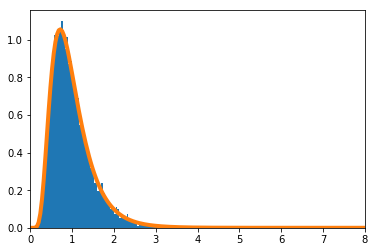

In [137]:
import numpy as np
import random

# mean and standard deviation of observed service times
# that appear to be lognormal distribution
m = 1
nu = .5

# mean and standard deviation of underlying normal distribution
mu = np.log(m/np.sqrt(1 + nu**2/m**2))
sigma = np.sqrt(np.log(1+nu**2/m**2))

print('mu = ', mu, 'sigma =', sigma)

# generate random variates from a lognormal distribution
t = [random.lognormvariate(mu,sigma) for k in range(0,10000)]
plt.hist(t,bins=100,normed=True)
print(np.mean(t),np.std(t))

# compare distributions
tp = np.linspace(0.001,12,300)
fLN = 1/(tp*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(tp) - mu)**2/2/sigma**2)
plt.plot(tp,fLN,lw=4)
plt.xlim(0,8)


## Random Service Time

Average time experienced by a customer =  4.54
Average queue length = 3.55813953488
Average number of customers in process = 4.56


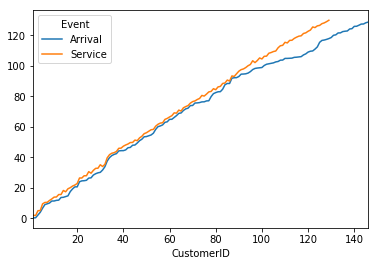

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1  # customers per minute

# random service time
mean_service_time = 1.8
std_service_time = .5
def random_service_time(m,nu):
    mu = np.log(m/np.sqrt(1 + nu**2/m**2))
    sigma = np.sqrt(np.log(1+nu**2/m**2))
    return random.lognormvariate(mu,sigma)

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(random_service_time(mean_service_time,std_service_time))
        log.append([n, env.now, 'Service'])
        
rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])
 
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(reporter(env))
env.run(130)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

## Let's add multiple Queues

Average time experienced by a customer =  4.07
Average queue length = 1.03335649757
Average number of customers in process = 2.03


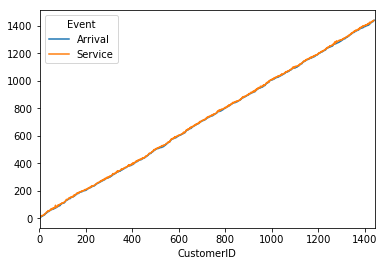

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1.0  # customers per minute

# random service time
mean_service_time = 3.0
std_service_time = 1.6
def random_service_time(m,nu):
    mu = np.log(m/np.sqrt(1 + nu**2/m**2))
    sigma = np.sqrt(np.log(1+nu**2/m**2))
    return random.lognormvariate(mu,sigma)

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(random_service_time(mean_service_time,std_service_time))
        log.append([n, env.now, 'Service'])
        
rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])

        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(reporter(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

Average time experienced by a customer =  504.12
Average queue length = 505.311327311
Average number of customers in process = 506.31


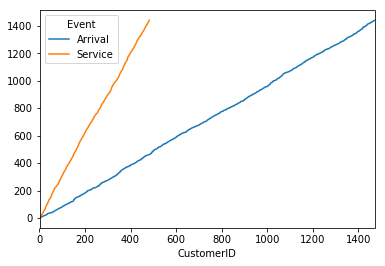

In [312]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1.0  # customers per minute

# random service time
mean_service_time = 3.0
std_service_time = 1.6
def random_service_time(m,nu):
    mu = np.log(m/np.sqrt(1 + nu**2/m**2))
    sigma = np.sqrt(np.log(1+nu**2/m**2))
    return random.lognormvariate(mu,sigma)

env = simpy.Environment()
customer_queue = simpy.Store(env)
agents = simpy.Resource(env,20)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        with agents.request() as req:
            yield req
            n = yield customer_queue.get()
            yield env.timeout(random_service_time(mean_service_time,std_service_time))
            log.append([n, env.now, 'Service'])
        
rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])

env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(reporter(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

<!--NAVIGATION-->
< [Model Development in SimPy](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.02-Discrete-Event-Simulation-of-a-Batch-Process.ipynb) | [Contents](toc.ipynb) | [Spanky's Pizzeria](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Spanky's-Pizzeria.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.03-Queuing-Systems.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>